# A/B testing

**Objective:**

Assess the correctness of the A/B test execution and analyze its results.

**Terms of reference**
- Test name: `recommender_system_test`;
- Groups: А (control), B (new payment funnel);
- Start date: 2020-12-07;
- Stop date for adding new users: 2020-12-21;
- End date: 2021-01-04;
- Audience: 15% of new users should be from the EU region;
- Purpose of the test: testing changes associated with the implementation of an improved recommendation system;
- Expected number of test participants: 6000;
- Expected effect: within 14 days of registration in the system, users will show an improvement in each metric by at least 10%:
  - conversion to viewing product pages — event `product_page`
  - conversion to viewing product cart — `product_cart`
  - conversion in purchase — `purchase`.

**Data Description:**

`/datasets/ab_project_marketing_events.csv` — calendar of marketing events for 2020;
- File structure: 
  - name — name of the marketing event;
  - regions — regions where the marketing campaign will be held;
  - start_dt — start date of the campaign;
  - finish_dt — end date of the campaign.


`/datasets/final_ab_new_users.csv` — all users who registered in the online store from December 7 to 21, 2020;
- File structure:
  - user_id — user identifier;
  - first_date — registration date;
  - region — user region;
  - device — the device from which the registration was made.

`/datasets/final_ab_events.csv` — all events of new users from December 7, 2020 to January 4, 2021;
- File structure:
  - user_id — user identifier;
  - event_dt — date and time of the event;
  - event_name — type of event;
  - details — additional data about the event. For example, for purchases this field stores the purchase cost in dollars.


`/datasets/final_ab_participants.csv` — table of test participants.
- File structure:
  - user_id — user identifier;
  - ab_test — test name;
  - group — user group.

## Data examination

In [121]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objects as go
import seaborn as sns

from datetime import datetime, timedelta
from scipy import stats as st
import numpy as np
import math as mth

In [122]:
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [123]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [124]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [125]:
# changing the datatype
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [126]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [127]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [128]:
# changing the datatype
users['first_date'] = pd.to_datetime(users['first_date'])

In [129]:
# number of users
users['user_id'].nunique()

61733

Every row in the table is a unique user.

In [130]:
#  number of users by region
users.groupby('region')['user_id'].count().sort_values()

region
APAC          3153
CIS           3155
N.America     9155
EU           46270
Name: user_id, dtype: int64

In [131]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [132]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [133]:
# changing the datatype
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [134]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [135]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [136]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

We have two tests:
 - recommender_system_test,
 - interface_eu_test.

The test that we need to analyze is called "recommender_system_test."

In [137]:
# number of participants in recommender_system_test
len(participants.query('ab_test == "recommender_system_test"'))

6701

In [138]:
# number of participants in interface_eu_test
len(participants.query('ab_test == "interface_eu_test"'))

11567

In [139]:
# checking for missing values
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [140]:
# checking for duplicates
marketing_events.duplicated().sum()

0

In [141]:
# checking for missing values
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [142]:
# checking for duplicates
users.duplicated().sum()

0

In [143]:
# min and max date
print("Min date:", users['first_date'].min())
print("Max date:", users['first_date'].max())

Min date: 2020-12-07 00:00:00
Max date: 2020-12-23 00:00:00


In [144]:
# checking for missing values
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [145]:
# find unique event names from the rows where the 'details' column is missing
list(events.loc[events['details'].isna()]['event_name'].unique())

['product_cart', 'product_page', 'login']

Everything is ok, there are missing values only in those cells where the purchase amount is not specified.

In [146]:
# checking for duplicates
events.duplicated().sum()

0

In [147]:
# checking for missing values
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [148]:
# checking for duplicates
participants.duplicated().sum()

0

**Summary:**

In the data preprocessing and exploration block, the data type has been modified, column names have been renamed, duplicates are absent. Missing values in the `details` column are due to the specific nature of the column: where there was no purchase amount, there is a missing value.

Each row in the `users` table represents a unique user.

The `participants` table contains 2 tests - `recommender_system_test`, `interface_eu_test`.

## Assess the correctness of the test

### Timeline of the tests

Let's see the earliest and latest registration dates of users in the `users` table.

In [149]:
print("Min date:", users['first_date'].min())
print("Max date:", users['first_date'].max())

Min date: 2020-12-07 00:00:00
Max date: 2020-12-23 00:00:00


In [150]:
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
new_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

new_participants.merge(new_users, on = 'user_id', how = 'left')\
    .query('ab_test == "recommender_system_test"')['first_date'].max()

'2020-12-21'

It is known that the launch date is 2020-12-07, and the date for stopping the acquisition of new users is 2020-12-21.

In [151]:
# create a new table by filtering the users whose "first_date" is later than December 21, 2020.
users12_21 = users.query('first_date <= "2020-12-21"')

End date: 2021-01-04. The 'events' table should contain all events of new users from December 7, 2020, to January 4, 2021. Let's check this statement:

In [152]:
print("Min date:", events['event_dt'].min())
print("Max date:", events['event_dt'].max())

Min date: 2020-12-07 00:00:33
Max date: 2020-12-30 23:36:33


We see that for some reason, our data ends on December 30, 2020. The test was stopped 5 days earlier.

In [153]:
# merge events and test_users
events_new = users12_21.merge(events, on='user_id', how='right')

Since we are interested in improving the metric only within 14 days from a user's registration, we need to check that events occurring after 14 days from a user's registration are excluded to focus on the 14-day lifetime.

In [154]:
# calculate liftime for each event
events_new['lifetime'] = (
events_new['event_dt'] - events_new['first_date']).dt.days

# limit the events in the table to those performed by users within a 2-week lifetime
events_new = events_new.query('lifetime < 14')

In [155]:
events_new

,user_id,first_date,region,device,event_dt,event_name,details,lifetime
0,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,2020-12-07 20:22:03,purchase,99.99,0.0
1,7B6452F081F49504,2020-12-07,EU,iPhone,2020-12-07 09:22:53,purchase,9.99,0.0
2,9CD9F34546DF254C,2020-12-07,N.America,iPhone,2020-12-07 12:59:29,purchase,4.99,0.0
3,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-07 04:02:40,purchase,4.99,0.0
4,1FD7660FDF94CA1F,2020-12-07,EU,Android,2020-12-07 10:15:09,purchase,4.99,0.0
...,...,...,...,...,...,...,...,...
440276,F393A2F75D0E8ED2,2020-12-20,EU,PC,2020-12-29 21:46:04,login,NaN,9.0
440277,9724329882446FD2,2020-12-20,EU,iPhone,2020-12-29 04:17:35,login,NaN,9.0
440278,DFAD5EDCE6BB4FD7,2020-12-20,N.America,PC,2020-12-29 10:40:54,login,NaN,9.0
440279,CAF67C6E072476F2,2020-12-20,N.America,PC,2020-12-29 14:54:02,login,NaN,9.0


In [156]:
# changing the name of the column
events_new = events_new.rename(columns={'event_dt': 'event_time'})
# creatin a new column with event date
events_new['event_date'] = events_new['event_time'].astype('datetime64[D]')

In [157]:
#result_grouped = events_new.pivot_table(index=['event_date'], columns='lifetime', values='user_id', aggfunc='nunique')
#result_grouped

The data in the user table was filtered until 2020-12-21. It was discovered that, for some reason, the test was stopped 5 days earlier (the `events` table ends on December 30, 2020). Events that occurred more than 14 days after the user's registration date were discarded.

### Overlap of test with marketing activities

Let's check for any overlap of test with marketing activities:

In [158]:
marketing_events.query('start_dt >= "2020-12-07" or finish_dt >= "2020-12-30"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [159]:
events_new

,user_id,first_date,region,device,event_time,event_name,details,lifetime,event_date
0,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,2020-12-07 20:22:03,purchase,99.99,0.0,2020-12-07
1,7B6452F081F49504,2020-12-07,EU,iPhone,2020-12-07 09:22:53,purchase,9.99,0.0,2020-12-07
2,9CD9F34546DF254C,2020-12-07,N.America,iPhone,2020-12-07 12:59:29,purchase,4.99,0.0,2020-12-07
3,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-07 04:02:40,purchase,4.99,0.0,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07,EU,Android,2020-12-07 10:15:09,purchase,4.99,0.0,2020-12-07
...,...,...,...,...,...,...,...,...,...
440276,F393A2F75D0E8ED2,2020-12-20,EU,PC,2020-12-29 21:46:04,login,NaN,9.0,2020-12-29
440277,9724329882446FD2,2020-12-20,EU,iPhone,2020-12-29 04:17:35,login,NaN,9.0,2020-12-29
440278,DFAD5EDCE6BB4FD7,2020-12-20,N.America,PC,2020-12-29 10:40:54,login,NaN,9.0,2020-12-29
440279,CAF67C6E072476F2,2020-12-20,N.America,PC,2020-12-29 14:54:02,login,NaN,9.0,2020-12-29


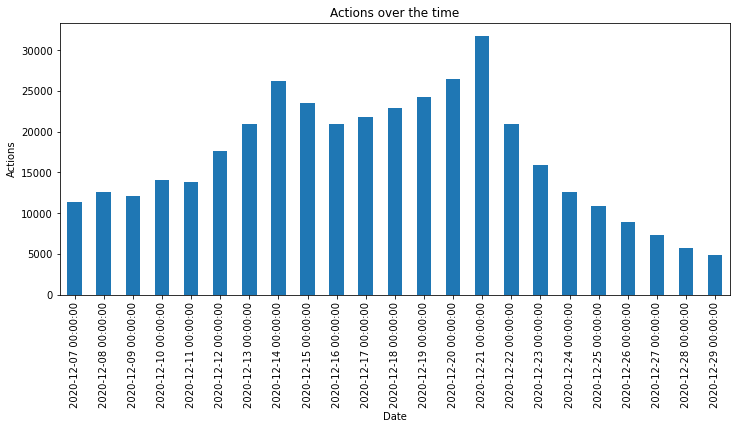

In [160]:
events_new.groupby('event_date')['event_time'].count().plot(kind='bar', figsize =(12,5))
plt.title('Actions over the time')
plt.ylabel("Actions")
plt.xlabel("Date")
plt.show()

In [161]:
test = events_new.merge(participants, on='user_id', how='inner')
test.head()

,user_id,first_date,region,device,event_time,event_name,details,lifetime,event_date,group,ab_test
0,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-07 04:02:40,purchase,4.99,0.0,2020-12-07,B,interface_eu_test
1,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-08 09:43:14,purchase,4.99,1.0,2020-12-08,B,interface_eu_test
2,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-09 00:44:10,purchase,4.99,2.0,2020-12-09,B,interface_eu_test
3,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-07 04:02:41,product_page,NaN,0.0,2020-12-07,B,interface_eu_test
4,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-08 09:43:18,product_page,NaN,1.0,2020-12-08,B,interface_eu_test


In [162]:
# unique users in both tests
test['user_id'].nunique()

12634

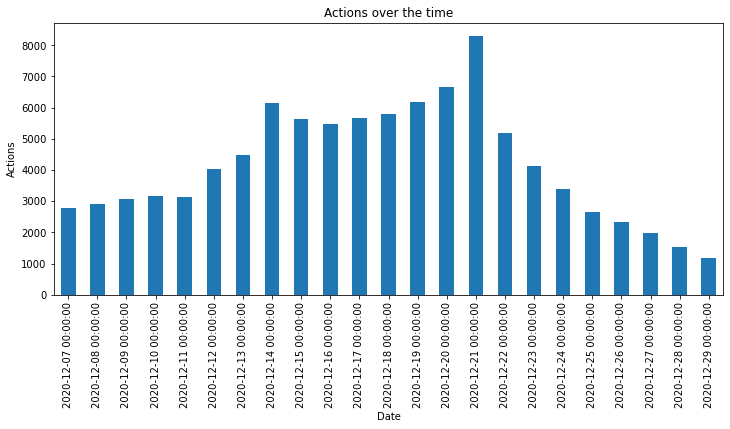

In [163]:
test.groupby('event_date')['event_time'].count().plot(kind='bar', figsize =(12,5))
plt.title('Actions over the time')
plt.ylabel("Actions")
plt.xlabel("Date")
plt.show()

There is an overlap between the test time and marketing activities, but they have no impact on the test.

### Number of participants 

In [164]:
test.head()

,user_id,first_date,region,device,event_time,event_name,details,lifetime,event_date,group,ab_test
0,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-07 04:02:40,purchase,4.99,0.0,2020-12-07,B,interface_eu_test
1,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-08 09:43:14,purchase,4.99,1.0,2020-12-08,B,interface_eu_test
2,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-09 00:44:10,purchase,4.99,2.0,2020-12-09,B,interface_eu_test
3,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-07 04:02:41,product_page,NaN,0.0,2020-12-07,B,interface_eu_test
4,96F27A054B191457,2020-12-07,EU,iPhone,2020-12-08 09:43:18,product_page,NaN,1.0,2020-12-08,B,interface_eu_test


Let's check the number of participants in the `recommender_system_test`. The expected number is 6000:

In [165]:
recommender_system_test = test.query('ab_test == "recommender_system_test"')

In [166]:
user_number_expected = 6000

# actual number of unique users in the recommender_system_test
user_number_fact = recommender_system_test['user_id'].nunique()
print('Number of unique users in "recommender_system_test" =', user_number_fact)

if user_number_fact >= user_number_expected:
    print('The number of users in the test meets the requirements')
else:
    print('The number of users in the test is less than expected')

Number of unique users in "recommender_system_test" = 3675
The number of users in the test is less than expected


The number of users in the recommender_system_test is clearly insufficient. 
Let's check if groups A and B are balanced:

In [167]:
# number of users in groups A and B in recommender_system_test
recommender_system_test.groupby('group')['user_id'].nunique().reset_index()

,group,user_id
0,A,2747
1,B,928


We can see that in group A, the number of participants is significantly higher than in group B, indicating an uneven distribution of users.

### Intersection of test audience

In [168]:
# number of users who are in both group A and B of "recommender_system_test" at the same time
len(np.intersect1d(recommender_system_test.query('group == "A"')['user_id'].unique(), 
                   recommender_system_test.query('group == "B"')['user_id'].unique()))

0

In [169]:
# number of users participating in both tests
len(np.intersect1d(recommender_system_test['user_id'].unique(), 
                   test.query('ab_test == "interface_eu_test"')['user_id'].unique()))

887

In this situation, the most appropriate solution would be to check which specific groups of `interface_eu_test` the users from `recommender_system_test` were assigned to. If they were only assigned to the control group, it means that the `interface_eu_test` test had no impact on them.

In [170]:
print("Number of users participating in the competitive test in group A (control):",
      len(np.intersect1d(recommender_system_test['user_id'].unique(), 
                   test.query('ab_test == "interface_eu_test" & group == "A"')['user_id'].unique())))

Number of users participating in the competitive test in group A (control): 456


In [171]:
print("Number of users participating in the competitive test in group B (test):",
      len(np.intersect1d(recommender_system_test['user_id'].unique(), 
                   test.query('ab_test == "interface_eu_test" & group == "B"')['user_id'].unique())))

Number of users participating in the competitive test in group B (test): 431


We must discard the number of users participating in the competitive test in group B:

In [172]:
# list of users from our test to remove
users_to_remove = np.intersect1d(recommender_system_test['user_id'].unique(), 
                   test.query('ab_test == "interface_eu_test" & group == "B"')['user_id'].unique()).tolist()

# remove these users from the table
recommender_system_test = recommender_system_test[~recommender_system_test['user_id'].isin(users_to_remove)]
recommender_system_test.reset_index(drop=True, inplace=True) 

In [173]:
recommender_system_test['user_id'].nunique()

3244

To determine the share of users from the European Union who participated in the test, out of the total number of users from that region registered on the platform between December 07 and December 21 (inclusive):

In [174]:
# доля участников теста из ЕС из общего числа пользователей ЕС с 07 по 21 декабря
round(recommender_system_test.query('region == "EU"')['user_id'].nunique() /
users12_21.query('region == "EU"')['user_id'].nunique() * 100 ,1)

7.2

In [175]:
users12_21.query('region == "EU"')['user_id'].nunique()

42340

In [176]:
regions = recommender_system_test.groupby('region')['user_id'].nunique().reset_index()
regions['share'] = round(regions['user_id'] / recommender_system_test['user_id'].nunique() * 100,1)
regions

,region,user_id,share
0,APAC,45,1.4
1,CIS,30,0.9
2,EU,3050,94.0
3,N.America,119,3.7


The share of participants from the EU is 7%, instead of the stated 15%.

We fell short of nearly half of the new users from the EU, but also, the total number of participants is almost 2 times lower than the stated number. Additionally, we removed users who are part of a competing test from the test group B.

**Conclusion:**

- We filtered the user table data and now only have users who registered no later than December 21, 2020.
- We discovered that for some reason, the `events` table data ends on December 30, 2020.
- We discarded events that occurred more than 14 days after a user's registration.
- We found out that marketing activities overlap with the test period but do not impact it in any way.
- We identified that the number of users in the `recommender_system_test` is less than expected (3244 vs 6000).
- We found that group A has significantly more participants than group B, indicating an uneven distribution of users.
- We determined that the share of test participants from the EU is 7%, instead of the projected 15%.
- We found out that in the `recommender_system_test`, there are no users who ended up in both group A and group B at the same time. However, there are 887 users who participated in both the `recommender_system_test` and the `interface_eu_test`.

## Exploratory data analysis

### Average number of events per user

In [177]:
# average number of events per user
round(recommender_system_test.shape[0] / recommender_system_test['user_id'].nunique())

6

In [178]:
recommender_system_test_a = recommender_system_test.query('group == "A"')
recommender_system_test_b = recommender_system_test.query('group == "B"')

In [179]:
# average number of events per user in group A
round(recommender_system_test_a.shape[0] 
      / recommender_system_test_a['user_id'].nunique())

7

In [180]:
# average number of events per user in group B
round(recommender_system_test_b.shape[0] 
      / recommender_system_test_b['user_id'].nunique())

5

Alpha (statistical significance level) - 0.05.

Define hypothesis (Null and Alternate):

- Null Hypothesis (H0) - users in groups A and B perform an equal number of actions on average.
- Alternative Hypothesis (H1) - users in groups A and B perform a different number of actions on average.

In [181]:
# find the number of actions users in group A perform
events_a = recommender_system_test_a.groupby('user_id')['event_time'].count()
# find the number of actions users in group B perform
events_b = recommender_system_test_b.groupby('user_id')['event_time'].count()

In [182]:
alpha = 0.05
# if p-value is less than alpha, we reject the null hypothesis

results = st.ttest_ind(events_a, events_b, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis, the average number of events per user is not equal')
else:
    print('Do not reject the null hypothesis, the average number of events per user is equal') 

p-value: 2.4206912959458938e-29
Reject the null hypothesis, the average number of events per user is not equal


### How is the number of events distributed per day in the groups?

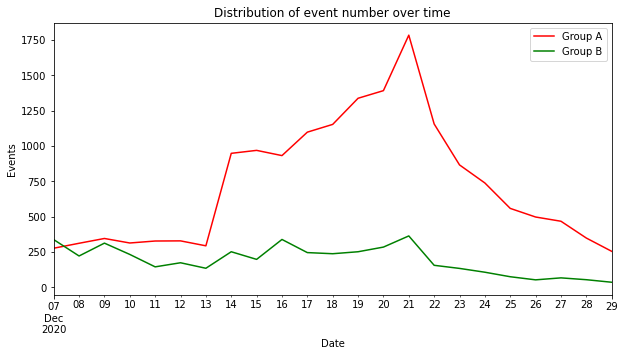

In [183]:
(recommender_system_test_a.groupby('event_date')['event_name']
.count().plot(color='r', figsize =(10,5)))
sns.lineplot(data = recommender_system_test_b.groupby('event_date')['event_name']
             .count(), label='label1', color='green')

plt.title('Distribution of event number over time')
plt.ylabel("Events")
plt.xlabel("Date")
plt.legend(['Group A', 'Group B'])
plt.show()

Group A stands out noticeably on the graph, as it has significantly more events compared to group B.

## Let's examine what could be the reason for the spike in events in group A on December 14th. We can explore the dynamics of user acquisition to gain insights.

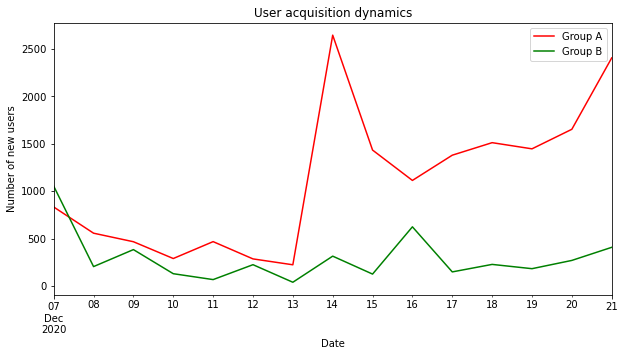

In [184]:
(recommender_system_test_a.groupby('first_date')['user_id']
.count().plot(color='r', figsize =(10,5)))
sns.lineplot(data = recommender_system_test_b.groupby('first_date')['user_id']
             .count(), label='label1', color='green')

plt.title('User acquisition dynamics')
plt.ylabel("Number of new users")
plt.xlabel("Date")
plt.legend(['Group A', 'Group B'])
plt.show()

A significant number of participants were added to group A on December 14th. User acquisition in the groups was unevenly distributed. This outlier is likely to distort the results.

### Conversion Funnel

In [185]:
#funnel_ab = (recommender_system_test.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index())

# swap the positions of the "purchase" and "product_cart" rows
#funnel_ab.iloc[2:4,:] = funnel_ab.iloc[[3,2],:]

#funnel_ab 

In [186]:
funnel_stage = ['login', 'product_page', 'product_cart', 'purchase']

def get_funnel(test, stages, title):
    funnel = (test.groupby('event_name')['user_id'].nunique()
             .sort_values(ascending=False).reset_index())

# building the funnel in the right order
    funnel['event_name'] = pd.Categorical(funnel['event_name'], categories=funnel_stage)
    funnel = funnel.sort_values('event_name')
    
    fig = go.Figure(go.Funnel(x=funnel['user_id'], y=stages, textinfo = 'value+percent initial'))
    fig.update_layout(title=title)
    
    return fig

funnel_ab = get_funnel(recommender_system_test, funnel_stage, 'A & B funnel')
funnel_ab.show()

In [187]:
funnel_a = get_funnel(recommender_system_test_a, funnel_stage, 'Group A funnel')
funnel_a.show()

In [188]:
funnel_b = get_funnel(recommender_system_test_b, funnel_stage, 'Group B funnel')
funnel_b.show()

We can see that group B has lower conversion rates at all stages. It is possible that the uneven distribution of users between groups A and B has influenced the distortion of the results.

Additionally, we can notice a nuance where some users made a purchase without going through the cart. Most likely, they purchased only one item. This could indicate that the funnel on the platform is not strict, and it is possible to make a purchase without going through certain stages. 

Let's assume that making a purchase can be done in 1 click without the need to visit the cart view.

### A/B test user segmentation

In [189]:
table = recommender_system_test.groupby(['group', 'device']).agg({'user_id': 'nunique'}).reset_index()

# add the column with number of users in A & B 
table_by_device = (table.merge(recommender_system_test.groupby('group')
                     .agg({'user_id': 'nunique'}).reset_index(), on='group'))
# changing names
table_by_device = table_by_device.rename(columns={'user_id_x': 'users_by_device', 'user_id_y': 'total_users'})

# add the column "share"
table_by_device['share'] = round(table_by_device['users_by_device'] / table_by_device['total_users'],2)

In [190]:
table_by_device

,group,device,users_by_device,total_users,share
0,A,Android,1061,2422,0.44
1,A,Mac,226,2422,0.09
2,A,PC,630,2422,0.26
3,A,iPhone,505,2422,0.21
4,B,Android,383,822,0.47
5,B,Mac,69,822,0.08
6,B,PC,200,822,0.24
7,B,iPhone,170,822,0.21


In [191]:
table_by_region = recommender_system_test.groupby(['group', 'region']).agg({'user_id': 'nunique'}).reset_index()

# add the column with number of users in A & B 
table_by_region = (table_by_region.merge(recommender_system_test.groupby('group')
                     .agg({'user_id': 'nunique'}).reset_index(), on='group'))
# changing names
table_by_region = table_by_region.rename(columns={'user_id_x': 'users_by_region', 'user_id_y': 'total_users'})

# add the column "share"
table_by_region['share'] = round(table_by_region['users_by_region'] / table_by_region['total_users'],2)
table_by_region

,group,region,users_by_region,total_users,share
0,A,APAC,28,2422,0.01
1,A,CIS,19,2422,0.01
2,A,EU,2279,2422,0.94
3,A,N.America,96,2422,0.04
4,B,APAC,17,822,0.02
5,B,CIS,11,822,0.01
6,B,EU,771,822,0.94
7,B,N.America,23,822,0.03


There is no significant distortion of proportions observed.

Prior to initiating A/B testing, it's essential to consider certain aspects of the data to ensure the validity of the results:

- The effects of outliers and anomalies within the total sample set should be mitigated;
- The tool utilized for traffic segmentation should perform without errors;
- Data should be accurately transmitted to the analytics systems;
- The disparity in user numbers across different groups should not exceed 1%;
- Uniform types of data should be captured for all groups and sent to the analytics systems;
- The divergence in key metrics between groups should not surpass 1% and should not hold statistical significance;
- Once a user is assigned to a group, they should remain within that group for the entire duration of the test. (Inconsistent user experiences across different versions of the test page may cloud the interpretation of results.)

Upon examining our specific case, we identify the following observations:
- The user count participating in the 'recommender_system_test' falls short of the expected number (3244 vs. 6000);
- Group A comprises thrice the number of participants as in group B, indicating an uneven user distribution;
- The mean number of events per user is 7 in group A and 5 in group B;
- Only 7% of the test participants are from the EU, as opposed to the expected 15%;
- User distribution across different devices is not homogeneous.

## Evaluation of the outcomes from the A/B testing

In [192]:
# number of unique users in Group A
a_users = recommender_system_test.query('group == "A"')['user_id'].nunique()
a_users

2422

In [193]:
# number of unique users in Group B
b_users = recommender_system_test.query('group == "B"')['user_id'].nunique()
b_users

822

In [194]:
ab_funnels = (recommender_system_test
              .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
              .sort_values('A', ascending = False).reset_index())
# swap the positions of the "purchase" and "product_cart" rows
ab_funnels.iloc[2:4,:] = ab_funnels.iloc[[3,2],:]

# remove login stage
ab_funnels = ab_funnels.drop([0]).set_index(ab_funnels.columns[0])
ab_funnels

group,A,B
event_name,,
product_page,1571,459
product_cart,728,225
purchase,773,226


As the threshold of statistical significance elevates, the risk of committing a Type I error—incorrectly rejecting a true null hypothesis—also escalates. For instance, with a statistical significance level set at 0.1, there's a 10% chance of falsely identifying a significant effect, leading to inaccurate conclusions. When conducting A/B testing, we leveraged the Shidak correction method to adjust the significance level, applying the formula: 1 - (1 - alpha)^(1/m), where m = 3 (the number of hypotheses).

Where alpha represents the statistical significance level.

Our hypotheses were articulated as follows:

- Null hypothesis (H0) - The users from groups A and B display no significant difference in conversion rates.
- Alternative hypothesis (H1) - The users from groups A and B display a significant difference in conversion rates.

In [195]:
alpha = 1 - (1 - 0.05)**(1/3)

def z_test(event_name):
    
    p1_event = ab_funnels.loc[event_name, 'A']
    p2_event = ab_funnels.loc[event_name, 'B'] 
    
    p1_users = recommender_system_test.query('group == "A"')['user_id'].nunique()
    p2_users = recommender_system_test.query('group == "B"')['user_id'].nunique()
    
    p1 = p1_event / p1_users # proportion of successes in the first group
    p2 = p2_event / p2_users # proportion of successes in the second group
    
    print('p1_event:', p1_event, 'p2_event:', p2_event, 'p1_users:', p1_users, 'p2_users:', p2_users)
   
    
    # proportion of successes in the combined dataset:
    p_combined = (p1_event + p2_event) / (p1_users + p2_users)
    
    difference = p1 - p2 # difference in proportions in the datasets
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Funnel stage - ', event_name)
    print('p-value: {:.2f}'.format(p_value))

    if p_value < alpha: 
        print('Reject the null hypothesis: there is a significant difference between the conversions')
    else:
        print('Failed to reject the null hypothesis, there is no reason to consider the conversions different')
    

In [196]:
for event_name in ab_funnels.index:
    z_test(event_name)
    print()

p1_event: 1571 p2_event: 459 p1_users: 2422 p2_users: 822
Funnel stage -  product_page
p-value: 0.00
Reject the null hypothesis: there is a significant difference between the conversions

p1_event: 728 p2_event: 225 p1_users: 2422 p2_users: 822
Funnel stage -  product_cart
p-value: 0.14
Failed to reject the null hypothesis, there is no reason to consider the conversions different

p1_event: 773 p2_event: 226 p1_users: 2422 p2_users: 822
Funnel stage -  purchase
p-value: 0.02
Failed to reject the null hypothesis, there is no reason to consider the conversions different



There is no reason to consider that users in groups A and B show different conversions of the `product_cart` and `purchase` events.

There is a difference between the conversions of the `product_page` event in groups A and B.

## Conclusion

The test has been conducted improperly due to several reasons:

- The test was stopped 5 days earlier;
- The participation count in the `recommender_system_test` is subpar, with only 3244 users instead of the projected 6000;
- the number of participants in group A is three times greater than in group B, which might be acceptable but deserves attention;
- The distribution of users into the two groups was not equal, as evidenced by an unexpected spike in new users in group A on December 14;
- The average event count per user varies across groups, with group A reporting 7 events per user, while group B accounts for only 5;
- The geographic representation is skewed, with only 7% of users from the EU, contrary to the anticipated 15%;
- The distribution of users across various devices is imbalanced.

The results of the A/B test cannot be considered conclusive. It's advisable to re-initiate the test, carefully addressing the shortcomings observed in this run. Furthermore, parallel testing should be avoided due to the potential for user overlap, which could compromise the results of both tests.